In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import stats
from matplotlib import ticker
from mpl_toolkits import mplot3d


1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.


Looking at the the 3d plot, we notice that 2 global minima exist.


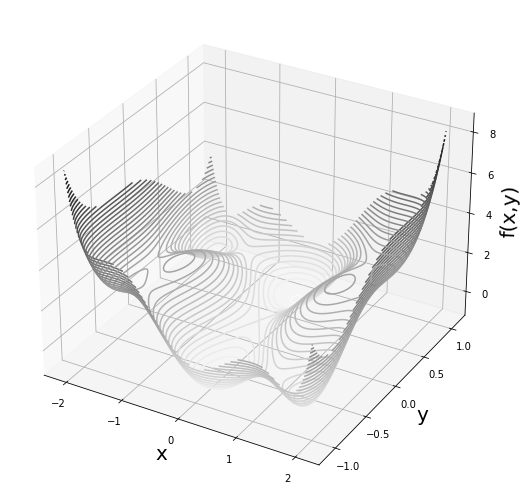

In [2]:
#define a function that takes in input a vector (x,y)
def f(v):
    x=v[0]
    y=v[1]
    return (4-2.1*x*x+x**4/3.)*x**2+x*y+(4*y*y-4)*y**2

x = np.arange(-2.1, 2.1, 0.01)
y = np.arange(-1.1, 1.1, 0.01)
X, Y = np.meshgrid(x,y)

#plotting in 3D
Z=f([X,Y])
fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x', size="20")
ax.set_ylabel('y', size="20")
ax.set_zlabel('f(x,y)', size="20");

print("\nLooking at the the 3d plot, we notice that 2 global minima exist.")

In [3]:
#try to minimize the function starting from a random point: (0,0)
solution = optimize.minimize(f, [0,0], bounds=[[-2,2],[-1,1]])
print("\nThe result of the minimization is:\t",solution.x)
print("\nSo, starting from (0,0), the algorythm doesn't give a good result, in fact on the previous plot we see that the two minima aren't in (0,0). The algorythm doesn't manage to reach the real minima.")


The result of the minimization is:	 [0. 0.]

So, starting from (0,0), the algorythm doesn't give a good result, in fact on the previous plot we see that the two minima aren't in (0,0). The algorythm doesn't manage to reach the real minima.


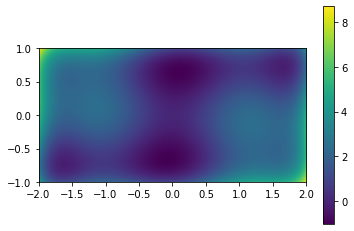

From the color plot we can find good guesses for the location of the global minima


In [4]:
#using a color plot
plt.imshow(f([X,Y]), extent=[-2, 2, -1, 1])
plt.colorbar()
plt.show()
print("From the color plot we can find good guesses for the location of the global minima")

In [5]:
solution = optimize.minimize(f, [0,-1], bounds=[[-2,2],[-1,1]])
print("\nThe first minimum is:\t",solution.x)
solution = optimize.minimize(f, [0,1], bounds=[[-2,2],[-1,1]])
print("\nThe second minimum is:\t",solution.x)


The first minimum is:	 [ 0.08984198 -0.71265639]

The second minimum is:	 [-0.08984199  0.71265638]


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

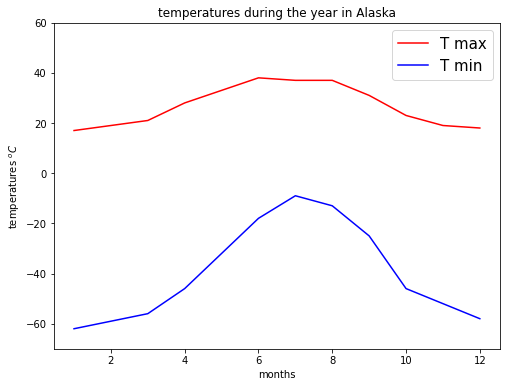

In [6]:
#plotting
T_max=np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
T_min=np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])

t=np.linspace(1,12,12)

fig = plt.figure(figsize=(8,6))

plt.plot(t,T_max, label="T max", color="red")
plt.plot(t,T_min, label="T min", color="blue")
plt.ylim(-70, 60)
plt.legend(prop={'size': 15})

plt.title('temperatures during the year in Alaska')
plt.xlabel('months')
plt.ylabel('temperatures $^o C$')
plt.show()

In [7]:
#defining the functions
def f_max(x, A_max, delta_max, max_average): 
    return A_max*np.sin(2*np.pi*x/12+delta_max)+max_average

def f_min(x, A_min, delta_min, min_average):
    return A_min*np.sin(2*np.pi*x/12+delta_min)+min_average

#fitting
popt_max, pcov_max=optimize.curve_fit(f=f_max, xdata=t, ydata=T_max)
popt_min, pcov_min=optimize.curve_fit(f=f_min, xdata=t, ydata=T_min)

#results
print("\nWe need a periodic function, since the temperatures should be the same in different years. We also want to keep the period fixed equal to one year. We let amplitude, temperature-offset and time-offset as parameters to find.")

print("\nThe values for amplitude_max/min, time-offset_max/min, temperature-offset_max/min are:\n", popt_max,"\n", popt_min)


We need a periodic function, since the temperatures should be the same in different years. We also want to keep the period fixed equal to one year. We let amplitude, temperature-offset and time-offset as parameters to find.

The values for amplitude_max/min, time-offset_max/min, temperature-offset_max/min are:
 [10.93254951 -1.9496096  26.75      ] 
 [-25.58169523   0.96549704 -39.66666666]


In [8]:
#Initializing the parameters to get results in a better format
print("\nWe need to initialize better the parameters, otherwise we get phenomenologically equivalent results nut in a form that lets understand less the fit. In fact for the minimum temperatures we have an additional t-offset of six moths (half a period), coupled with a minus sign on A.")

popt_max, pcov_max=optimize.curve_fit(f=f_max, xdata=t, ydata=T_max, p0=np.array([11, 4, 27]))
popt_min, pcov_min=optimize.curve_fit(f=f_min, xdata=t, ydata=T_min, p0=np.array([26, 4,-40]))

print("\nThe values for amplitude, time-offset and temperature-offset for the max temperatures are:\n", popt_max)
print("The values for amplitude, time-offset and temperature-offset for the min temperatures are:\n", popt_min,"\n\nWe can see that in fact the parameters are the same as before, except for the addition of a time-offset of a complete period.")

errors_max=np.sqrt(np.diag(pcov_max))
errors_min=np.sqrt(np.diag(pcov_min))

print("\nErros on the parameters of T_max:\n", errors_max)
print("Erros on the parameters of T_min:\n", errors_min)

rel_errors_max=np.sqrt(np.diag(pcov_max))/popt_max
rel_errors_min=np.sqrt(np.diag(pcov_min))/popt_min

print("\nRelative erros on the parameters of T_max:\n", rel_errors_max)
print("Relative erros on the parameters of T_min:\n", rel_errors_min)


We need to initialize better the parameters, otherwise we get phenomenologically equivalent results nut in a form that lets understand less the fit. In fact for the minimum temperatures we have an additional t-offset of six moths (half a period), coupled with a minus sign on A.

The values for amplitude, time-offset and temperature-offset for the max temperatures are:
 [10.93254951  4.33357571 26.75      ]
The values for amplitude, time-offset and temperature-offset for the min temperatures are:
 [ 25.58169519   4.10708969 -39.66666667] 

We can see that in fact the parameters are the same as before, except for the addition of a time-offset of a complete period.

Erros on the parameters of T_max:
 [0.56316181 0.0515124  0.39821554]
Erros on the parameters of T_min:
 [1.80599766 0.07059739 1.27703319]

Relative erros on the parameters of T_max:
 [0.0515124  0.01188681 0.01488656]
Relative erros on the parameters of T_min:
 [ 0.07059726  0.01718915 -0.03219411]


In [9]:
#changing some names for later
A_max=popt_max[0]
delta_max=popt_max[1]
max_average=popt_max[2]
A_min=popt_min[0]
delta_min=popt_min[1]
min_average=popt_min[2]

T_max_estimated=f_max(t, A_max, delta_max, max_average)
T_min_estimated=f_min(t, A_min, delta_min, min_average)

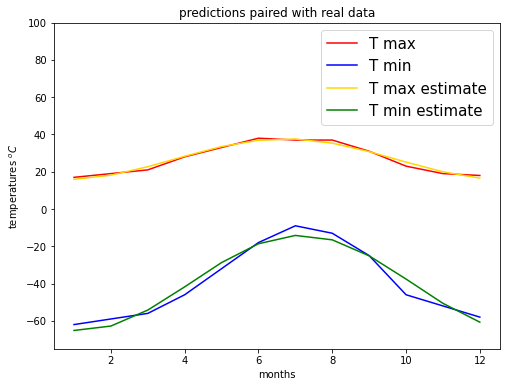

As we can see from both the plot and the estimation of the errors, the fit is pretty good.


In [10]:
#plot and fit together
fig = plt.figure(figsize=(8,6))

plt.plot(t,T_max, label="T max", color="red")
plt.plot(t,T_min, label="T min", color="blue")
plt.plot(t,T_max_estimated, label="T max estimate", color="gold")
plt.plot(t,T_min_estimated, label="T min estimate", color="green")
plt.ylim(-75, 100)
plt.legend(prop={'size': 15})
plt.title('predictions paired with real data')
plt.xlabel('months')
plt.ylabel('temperatures $^o C$')
plt.show()
print("As we can see from both the plot and the estimation of the errors, the fit is pretty good.")

In [11]:
#time-offsets of the max and min temperatures, verify if they are compatible
comp=np.abs(delta_max-delta_min)/np.sqrt(errors_max[1]**2+errors_min[1]**2)
print("the compatibility between the two time-offsets is: \t%2.3f" %(comp),"\nSo the time-offsets seem different.")

the compatibility between the two time-offsets is: 	2.592 
So the time-offsets seem different.


3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [12]:
#loading and restricting the dataset
file_name="/home/lorenzo/Programming/CompLabA/LaboratoryOfComputationalPhysics_Y4/residuals_261.pkl"
data=np.load(file_name,allow_pickle=True)
df = pd.DataFrame(data.item())
print("\nThere are in total:",len(df),"data.")

ranges=2
print("\nThe histogram would have some really long tails, especially on the left, while the interesting part is only close to zero. So we restrict the interval we study, since about 95% of the data is in the interval (",-ranges,",",ranges,").")
df=df.loc[(df['residuals'] >= -ranges) & (df['residuals'] <= ranges)]
print("\nThere are in total:",len(df),"data in the interval.")


There are in total: 11131 data.

The histogram would have some really long tails, especially on the left, while the interesting part is only close to zero. So we restrict the interval we study, since about 95% of the data is in the interval ( -2 , 2 ).

There are in total: 10490 data in the interval.


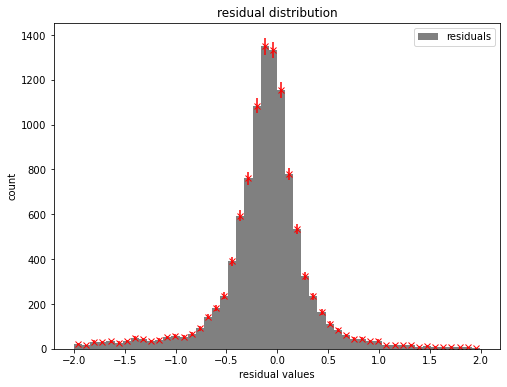

In [13]:
#plotting the hystogram
import matplotlib.pyplot as plt
bin_number=50
plt.figure(1, figsize=(8,6))
n, bins, patches = plt.hist(df["residuals"], bins=bin_number, label="residuals", color="grey")
plt.legend()
plt.xlabel("residual values")
plt.ylabel("count")
plt.title("residual distribution")
sigmas=n**0.5
plt.errorbar(x=0.5 * (bins[:-1] + bins[1:]), y=n, yerr=sigmas, marker='x', c='r', linestyle='None')

plt.show()

In [14]:
#centres of the bins
bins_r=bins[0:len(bins)-1]-(bins[0]-bins[1])/2

#defining fitting function
def gauss(x, mean_A, sig_A, A, mean_B, sig_B, B):
    G_A=A*np.exp(-np.power(x - mean_A, 2.) / (2 * np.power(sig_A, 2.)))
    G_B=B*np.exp(-np.power(x - mean_B, 2.) / (2 * np.power(sig_B, 2.)))
    return G_A+G_B
print("\nAs fitting function we consider the sum of two gaussians: the small FWHM wouldn't be compatible with the presence of not so fast-vanishing tails in the case of a single gaussian.")

#fitting
G_opt, G_cov=optimize.curve_fit(f=gauss, xdata=bins_r, ydata=n, p0=np.array([-0.1, 0.2, 1000, -1, 2, 50]), bounds=([-0.2,0.1,100,-5,0.4,1],[0.01,0.4,5000,2.5,5,500]), sigma=sigmas+1)
print("\nThe parameters obtained by the fit are:\n", G_opt)
print("\nTheir errors are:\n", np.sqrt(np.diag(G_cov)))


As fitting function we consider the sum of two gaussians: the small FWHM wouldn't be compatible with the presence of not so fast-vanishing tails in the case of a single gaussian.

The parameters obtained by the fit are:
 [-8.48976153e-02  2.13499367e-01  1.17807689e+03 -2.55512245e-01
  8.35816462e-01  9.61895260e+01]

Their errors are:
 [4.76297216e-03 4.90148185e-03 3.03791256e+01 4.03140245e-02
 4.67320797e-02 1.02019236e+01]


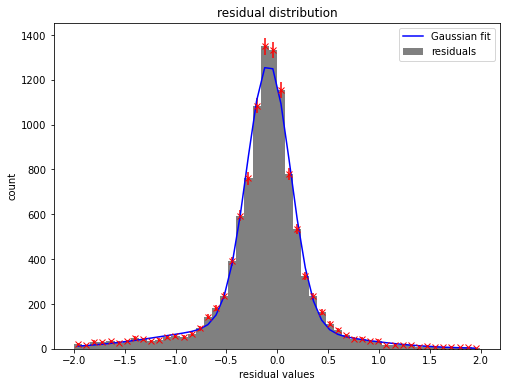

In [15]:
#plotting the fit on the hystogram
plt.figure(1, figsize=(8,6))
n, bins, patches = plt.hist(df["residuals"], bins=bin_number, label="residuals", color="grey")
plt.xlabel("residual values")
plt.ylabel("count")
plt.title("residual distribution")
sigmas=n**0.5
plt.errorbar(x=0.5 * (bins[:-1] + bins[1:]), y=n, yerr=sigmas, marker='x', c='r', linestyle='None')
plt.plot(bins_r,gauss(bins_r,G_opt[0],G_opt[1],G_opt[2],G_opt[3],G_opt[4],G_opt[5]), label="Gaussian fit", color="blue")
plt.legend()
plt.show()

In [16]:
#Chi squared
sqrs=(n-gauss(bins_r,G_opt[0],G_opt[1],G_opt[2],G_opt[3],G_opt[4],G_opt[5]))**2
sqrn=sqrs*(1/sigmas[np.isfinite(1/sigmas)])**2
chi2_int=np.inner(sqrn,sqrn)
print("Value of the chi^2 \t\t= %1.2e" % (chi2_int))

#p-value
dof = 5
pval = stats.chi2.sf(chi2_int,dof)
print("\np-value of the gaussian fit \t= %3.2e" % (pval))
print("\nThis is a really bad value.")


Value of the chi^2 		= 8.70e+02

p-value of the gaussian fit 	= 7.70e-186

This is a really bad value.


4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.

In [17]:
file_name="/home/lorenzo/Programming/CompLabA/LaboratoryOfComputationalPhysics_Y4/munich_temperatures_average_with_bad_data.txt"
data = pd.read_csv(file_name, sep=' ', names=['time','temp'])
display(data)

,time,temp
0,1995.00274,0.944444
1,1995.00548,-1.611110
2,1995.00821,-3.555560
3,1995.01095,-9.833330
4,1995.01369,-10.222200
...,...,...
6674,2013.27379,7.333330
6675,2013.27652,10.000000
6676,2013.27926,10.555600
6677,2013.28200,8.944440


The best parameters are:
A  = 9.962 ± 0.132
phi  = 2.907 ± 0.013
cost  = 9.263 ± 0.094

The average temperature in Munich is 8.94 °C

The typical daily average values predicted by the model for the coldest time of year is -0.70 °C

The typical daily average values predicted by the model for the hottest time of year 19.22 °C

b is a time-offset: physically it allows the fit to determine the position of the hottest time of the year. A shift of 2π has no effect, so what matters is the value of b module 2π.

In this model the hottest day of the year is after 196 days.


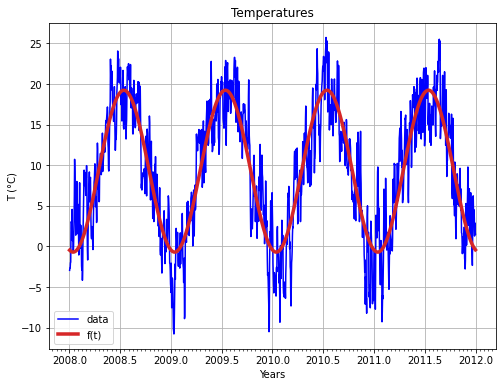

In [18]:
#defining functions
def f(t, a, b, c):
    return a * np.cos(2*np.pi*t + b) + c

def g(t, a, b, c, d):
    return a * np.cos(2*np.pi*b*t + c) + d

# filter data
trange = (2008<=data['time']) & (data['time']<=2012) & (np.abs(data['temp'])<75)
time, temp = data.loc[trange,'time'], data.loc[trange,'temp']

# fit f(x)
s_opt_a, s_cov_a = optimize.curve_fit(f=f, xdata=time, ydata=temp, p0=[10,3,10], bounds=([5,-7,5], [15,7,15]))
sig_a = (np.diag(s_cov_a))**0.5

# plot data
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(time, temp, label='data', color='blue')
ax.grid()
ax.set_title("Temperatures")
ax.set_ylabel("T (°C)")
ax.set_xlabel("Years")
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(12))

# plot f(t)
x0 = np.linspace(time.head(1).values,time.tail(1).values,1000)
ax.plot(x0, f(x0, s_opt_a[0], s_opt_a[1], s_opt_a[2]), c='C3', alpha=1, label='f(t)', lw=3.5)

print("The best parameters are:")
print("A  = %2.3f ± %2.3f" % (s_opt_a[0], sig_a[0]))
print("phi  = %2.3f ± %2.3f" % (s_opt_a[1], sig_a[1]))
print("cost  = %2.3f ± %2.3f" % (s_opt_a[2], sig_a[2]))

print("\nThe average temperature in Munich is %2.2f °C"% data['temp'].mean())
print("\nThe typical daily average values predicted by the model for the coldest time of year is %2.2f °C" % (-s_opt_a[0]+s_opt_a[2]))
print("\nThe typical daily average values predicted by the model for the hottest time of year %2.2f °C" % (s_opt_a[0]+s_opt_a[2]))
print("\nb is a time-offset: physically it allows the fit to determine the position of the hottest time of the year. A shift of 2π has no effect, so what matters is the value of b module 2π.")
print("\nIn this model the hottest day of the year is after %i days." % ( (1-(s_opt_a[1]/(2*np.pi)))*365.25 ))

ax.legend()
plt.show()

The best parameters are:
A  = 9.961 ± 0.133
omega  = 1.000 ± 0.002
phi  = -0.780 ± 23.791
cost  = 9.266 ± 0.096


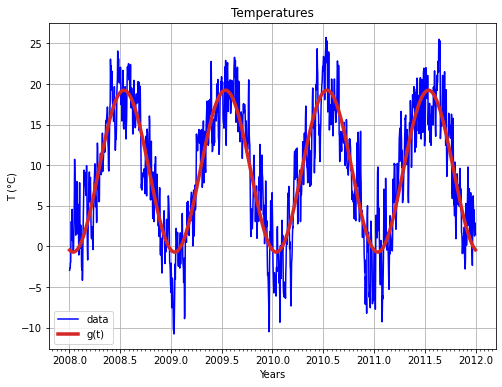

In [19]:
# fit g(x)
s_opt_b, s_cov_b = optimize.curve_fit(f=g, xdata=time, ydata=temp, p0=[10,1,3,10], bounds=([5,0,-7,5], [15,2,7,15]))
sig_b = (np.diag(s_cov_b))**0.5

# plot data
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(time, temp, label='data', color='blue')
ax.grid()
ax.set_title("Temperatures")
ax.set_ylabel("T (°C)")
ax.set_xlabel("Years")
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(12))

# plot f(t)
x0 = np.linspace(time.head(1).values,time.tail(1).values,1000)
ax.plot(x0, g(x0, s_opt_b[0], s_opt_b[1], s_opt_b[2], s_opt_b[3]), c='C3', alpha=1, label='g(t)', lw=3.5)
ax.legend()
fig
print("The best parameters are:")
print("A  = %2.3f ± %2.3f" % (s_opt_b[0], sig_b[0]))
print("omega  = %2.3f ± %2.3f" % (s_opt_b[1], sig_b[1]))
print("phi  = %2.3f ± %2.3f" % (s_opt_b[2], sig_b[2]))
print("cost  = %2.3f ± %2.3f" % (s_opt_b[3], sig_b[3]))

In [20]:

# SSR
RSS_a = np.sum(np.power(f(time,s_opt_a[0],s_opt_a[1],s_opt_a[2])-temp, 2.))
RSS_b = np.sum(np.power(g(time,s_opt_b[0],s_opt_b[1],s_opt_b[2],s_opt_b[3])-temp, 2.))
dof_a = 3 - 1
dof_b = 4 - 1
print("\nThe RSS of f(x) is %2.0f" % (RSS_a))
print("\nThe RSS of g(x) is %2.0f" % (RSS_b))

# F-Test
F = ((RSS_a-RSS_b)/(dof_b-dof_a))/(RSS_b/(len(time)-dof_b))
CL = stats.f.sf(F, dof_b - dof_a, len(time) - dof_b)
print("\nThe F-test result is %2.3f" % (F))
print("\nThe Confidence level is %2.3f" % (CL))
print("\nThe performances of g and f are the same.")



The RSS of f(x) is 18670

The RSS of g(x) is 18669

The F-test result is 0.023

The Confidence level is 0.880

The performances of g and f are the same.
